In [1]:
# Import Dependencies
import pandas as pd
from sqlalchemy import create_engine
import datetime
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
import re
import networkx
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nltk'

In [2]:
# Create engine 
engine = create_engine("sqlite:///data/hashtag2020.db", echo=True)
conn = engine.connect()

2021-02-10 15:50:10,245 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-10 15:50:10,246 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:50:10,250 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-10 15:50:10,251 INFO sqlalchemy.engine.base.Engine ()


In [3]:
#Create the table. If we use automap_base, the table must have a primary key
conn.execute("""
    CREATE TABLE IF NOT EXISTS tweet_counts (
        id integer PRIMARY KEY,
        created_at TEXT,
        tweet VARCHAR(280),
        likes integer,
        retweet_count integer,
        source VARCHAR(30),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Date TEXT,
        Time TEXT,
        polarity integer,
        analysis VARCHAR(20)
        
    )
""")

2021-02-10 15:50:11,028 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS tweet_counts (
        id integer PRIMARY KEY,
        created_at TEXT,
        tweet VARCHAR(280),
        likes integer,
        retweet_count integer,
        source VARCHAR(30),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Date TEXT,
        Time TEXT,
        polarity integer,
        analysis VARCHAR(20)
        
    )

2021-02-10 15:50:11,030 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:50:11,036 INFO sqlalchemy.engine.base.Engine COMMIT


In [4]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS state_avg (
        state_code VARCHAR(5) PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )
""")

2021-02-10 15:50:11,742 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS state_avg (
        state_code VARCHAR(5) PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )

2021-02-10 15:50:11,743 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:50:11,745 INFO sqlalchemy.engine.base.Engine COMMIT


In [5]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS time_avg (
        Date TEXT PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )
""")

2021-02-10 15:50:12,345 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS time_avg (
        Date TEXT PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )

2021-02-10 15:50:12,347 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:50:12,349 INFO sqlalchemy.engine.base.Engine COMMIT


In [6]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS sent_count (
        count_id integer PRIMARY KEY,
        analysis VARCHAR(20),
        Biden_Count integer,
        Trump_Count integer
       
    )
""")

2021-02-10 15:50:12,951 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS sent_count (
        count_id integer PRIMARY KEY,
        analysis VARCHAR(20),
        Biden_Count integer,
        Trump_Count integer
       
    )

2021-02-10 15:50:12,952 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:50:12,954 INFO sqlalchemy.engine.base.Engine COMMIT


In [7]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS time_tweets (
        id integer PRIMARY KEY,
        created_at TEXT,
        trump integer,
        biden integer
        
    )
""")

2021-02-10 15:50:13,540 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS time_tweets (
        id integer PRIMARY KEY,
        created_at TEXT,
        trump integer,
        biden integer
        
    )

2021-02-10 15:50:13,541 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:50:13,543 INFO sqlalchemy.engine.base.Engine COMMIT


In [8]:
# Read in CSV's and build initial combined dataframe
trump_csv_path = "../hashtag_donaldtrump.csv"
biden_csv_path = "../hashtag_joebiden.csv"

In [9]:
trump_data_df = pd.read_csv(trump_csv_path, lineterminator='\n')
biden_data_df = pd.read_csv(biden_csv_path, lineterminator='\n')

In [10]:
trump_data_df["hashtag"]="Trump"
biden_data_df["hashtag"]="Biden"

In [11]:
tweet_df = pd.concat([trump_data_df, biden_data_df])

In [12]:
tweet_df["created_at"]=pd.to_datetime(tweet_df.created_at)

In [13]:
tweet_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970917,2020-11-08 23:59:54,1.325589e+18,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",0.0,0.0,Twitter for iPad,7.687811e+08,Debra,drdeblk,MD. Autism specialist. Film lover. #DumpTrump2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:56.012674,Trump
970918,2020-11-08 23:59:55,1.325589e+18,OK just had to do it !\n#Trump #CatapultTrump ...,105.0,28.0,Twitter Web App,4.519791e+08,Dunken K Bliths,DunkenKBliths,"""Tesla owner's will be followed back""\n\n#Mach...",...,✔ Official Twitter Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.807500,Trump
922910,2020-11-08 23:59:56,1.325589e+18,@nbcbayarea Who doesn’t like dogs or any kind ...,1.0,1.0,Twitter for iPhone,1.182639e+08,Dianna Maria,DiannaMaria,"~ I am a very proud mom of a sweet, kind and c...",...,United States,39.783730,-100.445882,NaN,United States,North America,NaN,NaN,2020-11-09 17:46:06.939099,Trump
737089,2020-11-08 23:59:57,1.325589e+18,#JoeBiden 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 https://t.co/Ym...,0.0,0.0,Twitter for iPhone,1.148479e+08,Nataša,PewPeeew,My brain consists of coping mechanisms and vin...,...,Deutschland,51.083420,10.423447,NaN,Germany,Europe,NaN,NaN,2020-11-09 18:26:04.550843,Biden


In [14]:
usa = {"United States of America" : "United States"}
tweet_df['country'].replace(usa, inplace=True)

In [ ]:
clean_df = tweet_df.dropna(how='any')

In [ ]:
# Filter to data for United States only
clean_df = clean_df.loc[clean_df['country']== 'United States']

In [ ]:
print("Count of duplicates: {}".format(clean_df.duplicated(subset=["tweet"]).sum()))

In [ ]:
# Remove duplicate tweets, leaving only those with either hashtag not both
print("Original size of df: {}".format(len(clean_df)))
clean_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(clean_df)))

In [ ]:
clean_df.reset_index(inplace=True)

In [ ]:
clean_df['Date'] = clean_df['created_at'].dt.strftime('%m/%d/%Y')
clean_df['Time'] = clean_df['created_at'].dt.strftime('%H:%M:%S')

In [ ]:
# Setting id column to use as primary key
clean_df = clean_df.rename(columns = {'index': 'id'}, inplace = False)

In [ ]:
clean_df = clean_df[['id', 'created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time']]

In [ ]:
clean_df = clean_df[['created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time']]

In [ ]:
clean_df.reset_index(inplace=True)

In [ ]:
clean_df = clean_df.rename(columns = {'index': 'id'}, inplace = False)
clean_df.head()

In [ ]:
clean_df['id'].value_counts()

In [ ]:
# Sentiment Analysis - code created by Try Suharso https://www.kaggle.com/trysuharso (2020) Pandas, NLTK, Re, TextBlob, Networkx. [Source code]. https://www.kaggle.com/trysuharso/us-election-2020-twitter-analysis

In [ ]:
#cleaning the tweets
def clean_tweets(tweet):
 
    tweet = re.sub(r':', '', str(tweet))
    tweet = re.sub(r'‚Ä¶', '', str(tweet))
    tweet = re.sub('@[A-Za-z0–9]+', '', str(tweet))               
    tweet = re.sub('#', '', str(tweet)) # Removing '#' hash tag
    tweet = re.sub('https?:\/\/\S+', '', str(tweet)) # Removing hyperlink
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ',str(tweet))
    tweet = str(tweet).lower()
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'RT[\s]+','',tweet)
    tweet = re.sub(r'[^\w]', ' ', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('https ', '', tweet)
    tweet = re.sub('co', '', tweet)

    return tweet

In [ ]:
# Determine subjectivity, polarity, sentiment values of each tweet 
# ALLOW SEVERAL MINUTES TO COMPLETE
def getSubjectivity(tweet):
    try:
        return TextBlob(tweet).sentiment.subjectivity
    except:
        return None


# Create a function to get the polarity
def getPolarity(tweet):
    try:
        return  TextBlob(tweet).sentiment.polarity
    except:
        return None

def sentiment_calc(tweet):
    try:
        return TextBlob(tweet).sentiment
    except:
        return None

# Add sentiment analysis value columns to df
clean_df['edited_tweet'] = clean_df['tweet'].apply(clean_tweets)
clean_df['subjectivity'] = clean_df['edited_tweet'].apply(getSubjectivity)
clean_df['polarity'] = clean_df['edited_tweet'].apply(getPolarity)
clean_df['sentiment'] = clean_df['edited_tweet'].apply(sentiment_calc)

# Assign sentiment analysis category based on polarity value and add to df
def getAnalysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

clean_df['analysis'] = clean_df['polarity'].apply(getAnalysis)

In [ ]:
clean_df.head()

In [ ]:
# Creating dataframe for polarity average by state
biden=clean_df[clean_df['hashtag']=='Biden']
trump=clean_df[clean_df['hashtag']=='Trump']

In [ ]:
biden['Pol_Avg'] = biden.groupby('state_code').polarity.transform('mean')
trump['Pol_Avg'] = trump.groupby('state_code').polarity.transform('mean')


In [ ]:
biden = biden[['state_code','lat', 'long', 'hashtag','Pol_Avg' ]]
trump = trump[['state_code','lat', 'long', 'hashtag','Pol_Avg' ]]

In [ ]:
biden = biden.drop_duplicates(subset=['state_code'], keep='first')
trump = trump.drop_duplicates(subset=['state_code'], keep='first')

In [ ]:
biden['analysis'] = biden['Pol_Avg'].apply(getAnalysis)
trump['analysis'] = trump['Pol_Avg'].apply(getAnalysis)

In [ ]:
biden['analysis'].value_counts()

In [ ]:
trump['analysis'].value_counts()

In [ ]:
biden.head()

In [ ]:
biden = biden.rename(columns = {'Pol_Avg': 'BidenAvg'}, inplace = False).reset_index()
trump = trump.rename(columns = {'Pol_Avg': 'TrumpAvg'}, inplace = False).reset_index()

In [ ]:
biden = biden[['state_code', 'BidenAvg']]
trump = trump[['state_code', 'TrumpAvg']]

In [ ]:
state_avg = pd.merge(biden, trump, on="state_code", how="left")

In [ ]:
state_avg = state_avg.reset_index(drop=True)

In [ ]:
state_avg.head()

In [ ]:
# Sentiment by date

In [ ]:
biden1=clean_df[clean_df['hashtag']=='Biden']
trump1=clean_df[clean_df['hashtag']=='Trump']

In [ ]:
biden1['Pol_Avg'] = biden1.groupby('Date').polarity.transform('mean')
trump1['Pol_Avg'] = trump1.groupby('Date').polarity.transform('mean')

In [ ]:
biden1.head()

In [ ]:
biden1 = biden1.drop_duplicates(subset=['Date'], keep='first')
trump1 = trump1.drop_duplicates(subset=['Date'], keep='first')

In [ ]:
biden1 = biden1.rename(columns = {'Pol_Avg': 'BidenAvg'}, inplace = False).reset_index()
trump1 = trump1.rename(columns = {'Pol_Avg': 'TrumpAvg'}, inplace = False).reset_index()

In [ ]:
biden1 = biden1[['Date', 'BidenAvg']]
trump1 = trump1[['Date', 'TrumpAvg']]

In [ ]:
time_avg = pd.merge(biden1, trump1, on="Date", how="left")

In [ ]:
time_avg = time_avg.reset_index(drop=True)

In [ ]:
time_avg.head()

In [ ]:
# Creating dataframe for sentiment counts bar visual
biden_count=clean_df[clean_df['hashtag']=='Biden']
trump_count=clean_df[clean_df['hashtag']=='Trump']


In [ ]:
biden_count = biden_count[['analysis', 'hashtag']]
trump_count = trump_count[['analysis', 'hashtag']]

In [ ]:
biden_count["count"]=1
trump_count["count"]=1

In [ ]:
biden_count.head()

In [ ]:
biden_count = biden_count.rename(columns = {'count': 'Biden_Count'}, inplace = False)
trump_count = trump_count.rename(columns = {'count': 'Trump_Count'}, inplace = False)

In [ ]:
biden_count.head()

In [ ]:
biden_count = biden_count.groupby('analysis').count().reset_index()
trump_count = trump_count.groupby('analysis').count().reset_index()

In [ ]:
biden_count = biden_count[['analysis', 'Biden_Count']]
trump_count = trump_count[['analysis', 'Trump_Count']]

In [ ]:
sent_count = pd.merge(biden_count, trump_count, on="analysis", how="left")
sent_count

In [ ]:
sent_count = sent_count.reset_index(drop=True)

In [ ]:
sent_count

In [ ]:

sent_count = sent_count.reset_index(drop=True)

In [ ]:
sent_count.reset_index(inplace=True)
sent_count = sent_count.rename(columns = {'index': 'count_id'}, inplace = False)

In [ ]:
sent_count

In [ ]:
clean_df = clean_df[['id', 'created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time', 'polarity', 'analysis']]

In [ ]:
clean_df.head()

In [ ]:
clean_df.to_sql("tweet_counts", conn, if_exists="append", index=False)


In [ ]:
state_avg.to_sql("state_avg", conn, if_exists="append", index=False)

In [ ]:
time_avg.to_sql("time_avg", conn, if_exists="append", index=False)

In [ ]:
sent_count.to_sql("sent_count", conn, if_exists="append", index=False)

# Buckley's Code

In [15]:
trump_data_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970915,2020-11-08 23:59:48,1.325589e+18,JOE BIDEN WHY JOE BIDEN DID WINNED ?? TRUMP TR...,4.0,0.0,Twitter Web App,3.245258e+09,ahzy,ahhhzy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.715870,Trump
970916,2020-11-08 23:59:53,1.325589e+18,#AfD|ler reagieren panisch bis hysterisch auf ...,25.0,4.0,Twitter Web App,9.866108e+17,watchdog,wilke_tobias,Quis custodiet ipsos custodes?\n\nTV Journalis...,...,Saxony/GER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.975868,Trump
970917,2020-11-08 23:59:54,1.325589e+18,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",0.0,0.0,Twitter for iPad,7.687811e+08,Debra,drdeblk,MD. Autism specialist. Film lover. #DumpTrump2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:56.012674,Trump
970918,2020-11-08 23:59:55,1.325589e+18,OK just had to do it !\n#Trump #CatapultTrump ...,105.0,28.0,Twitter Web App,4.519791e+08,Dunken K Bliths,DunkenKBliths,"""Tesla owner's will be followed back""\n\n#Mach...",...,✔ Official Twitter Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.807500,Trump


In [16]:
biden_data_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,Biden
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,Biden
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849,Biden
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,Biden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776882,2020-11-08 23:59:38,1.325589e+18,Ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του...,0.0,0.0,Twitter for Android,4.032819e+08,οχι άλλο κάρβουνο 🇬🇷🗣🗣🗣,anapodoi,ακραία καιρικά φαινόμενα... ζήσαμε και απόψε,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.947617,Biden
776883,2020-11-08 23:59:41,1.325589e+18,L'OTAN va sortir de sa léthargie et redevenir ...,48.0,14.0,Twitter for Android,7.819183e+17,🇫🇷 Alt-Droite (matricule 6921) ✝️ 🇬🇷 🇮🇹 🇦🇲,CtrlAltDroite,Fils de mineur. Libertés - Identité - Solidari...,...,France,46.603354,1.888334,NaN,France,Europe,NaN,NaN,2020-11-09 18:32:45.627335,Biden
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,5.293315e+08,Angelo Tani,AngeloTani,nato a casa dei nonni,...,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846,Biden
737089,2020-11-08 23:59:57,1.325589e+18,#JoeBiden 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 https://t.co/Ym...,0.0,0.0,Twitter for iPhone,1.148479e+08,Nataša,PewPeeew,My brain consists of coping mechanisms and vin...,...,Deutschland,51.083420,10.423447,NaN,Germany,Europe,NaN,NaN,2020-11-09 18:26:04.550843,Biden


In [17]:
usa = {"United States of America" : "United States"}
trump_data_df['country'].replace(usa, inplace=True)
biden_data_df['country'].replace(usa, inplace=True)

In [18]:
trump_data_df = trump_data_df.dropna(how='any')
biden_data_df = biden_data_df.dropna(how='any')

In [19]:
trump_data_df = trump_data_df.loc[trump_data_df['country']== 'United States']
biden_data_df = biden_data_df.loc[biden_data_df['country']== 'United States']

In [20]:
print("Count of duplicates: {}".format(trump_data_df.duplicated(subset=["tweet"]).sum()))
print("Count of duplicates: {}".format(biden_data_df.duplicated(subset=["tweet"]).sum()))

Count of duplicates: 1421
Count of duplicates: 807


In [21]:
print("Original size of df: {}".format(len(trump_data_df)))
trump_data_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(trump_data_df)))

print("Original size of df: {}".format(len(biden_data_df)))
biden_data_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(biden_data_df)))

Original size of df: 96623
No duplicates size of df : 94581
Original size of df: 85761
No duplicates size of df : 84461


In [22]:
trump_data_df.reset_index(inplace=True)
biden_data_df.reset_index(inplace=True)

In [23]:
trump_data_df.head(3)

,index,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [24]:
trump_data_df = trump_data_df.rename(columns = {'index': 'id'}, inplace = False)
trump_data_df.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [25]:
biden_data_df = biden_data_df.rename(columns = {'index': 'id'}, inplace = False)
biden_data_df.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:03.106963698,Biden
1,17,2020-10-15 00:01:23,1.316530e+18,"Comments on this? ""Do Democrats Understand how...",0.0,0.0,Twitter Web App,1.016593e+08,John Ubaldi,ubaldireports,...,"Tampa, Florida",27.947760,-82.458444,Tampa,United States,North America,Florida,FL,2020-10-21 00:00:08.803063811,Biden
2,25,2020-10-15 00:01:57,1.316530e+18,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,Twitter for Android,1.300837e+18,Sam KEYS,SamKEYS65729181,...,"Los Angeles, CA",34.053691,-118.242766,Los Angeles,United States,North America,California,CA,2020-10-21 00:00:12.945682075,Biden


In [26]:
t_time_series = pd.Series(1, index=trump_data_df['created_at'])
t_time_series.head(3)

created_at
2020-10-15 00:00:02    1
2020-10-15 00:00:08    1
2020-10-15 00:00:25    1
dtype: int64

In [27]:
b_time_series = pd.Series(1, index=biden_data_df['created_at'])
b_time_series.head(3)

created_at
2020-10-15 00:00:25    1
2020-10-15 00:01:23    1
2020-10-15 00:01:57    1
dtype: int64

In [28]:
# Converting the index as date
t_time_series.index = pd.to_datetime(t_time_series.index)
trump_df = t_time_series.resample('12H').sum()
trump_df.head(3)

created_at
2020-10-15 00:00:00    1063
2020-10-15 12:00:00    1535
2020-10-16 00:00:00    1912
Freq: 12H, dtype: int64

In [29]:
b_time_series.index = pd.to_datetime(b_time_series.index)
biden_df = b_time_series.resample('12H').sum()
biden_df.head(3)

created_at
2020-10-15 00:00:00     814
2020-10-15 12:00:00    1239
2020-10-16 00:00:00    1601
Freq: 12H, dtype: int64

In [30]:
t_time_series_df = pd.DataFrame(trump_df)
t_time_series_df.head()

,0
created_at,
2020-10-15 00:00:00,1063
2020-10-15 12:00:00,1535
2020-10-16 00:00:00,1912
2020-10-16 12:00:00,1958
2020-10-17 00:00:00,874


In [31]:
b_time_series_df = pd.DataFrame(biden_df)
b_time_series_df.head()

,0
created_at,
2020-10-15 00:00:00,814
2020-10-15 12:00:00,1239
2020-10-16 00:00:00,1601
2020-10-16 12:00:00,1366
2020-10-17 00:00:00,612


In [32]:
combined_df = pd.concat([t_time_series_df, b_time_series_df], axis=1, join="inner")
combined_df.head()

,0,0
created_at,,
2020-10-15 00:00:00,1063,814
2020-10-15 12:00:00,1535,1239
2020-10-16 00:00:00,1912,1601
2020-10-16 12:00:00,1958,1366
2020-10-17 00:00:00,874,612


In [33]:
combined_df.columns = ['trump', 'biden']
combined_df.head(3)

,trump,biden
created_at,,
2020-10-15 00:00:00,1063,814
2020-10-15 12:00:00,1535,1239
2020-10-16 00:00:00,1912,1601


In [38]:
combined_df.reset_index(inplace=True)



,index,created_at,trump,biden
0,0,2020-10-15 00:00:00,1063,814
1,1,2020-10-15 12:00:00,1535,1239
2,2,2020-10-16 00:00:00,1912,1601
3,3,2020-10-16 12:00:00,1958,1366
4,4,2020-10-17 00:00:00,874,612
5,5,2020-10-17 12:00:00,1382,1009
6,6,2020-10-18 00:00:00,800,478
7,7,2020-10-18 12:00:00,1616,1012
8,8,2020-10-19 00:00:00,841,536
9,9,2020-10-19 12:00:00,1867,1110


In [40]:
combined_df = combined_df[['created_at','trump','biden']]
combined_df.head(3)

,created_at,trump,biden
0,2020-10-15 00:00:00,1063,814
1,2020-10-15 12:00:00,1535,1239
2,2020-10-16 00:00:00,1912,1601


Text(0, 0.5, 'Number of Tweets')

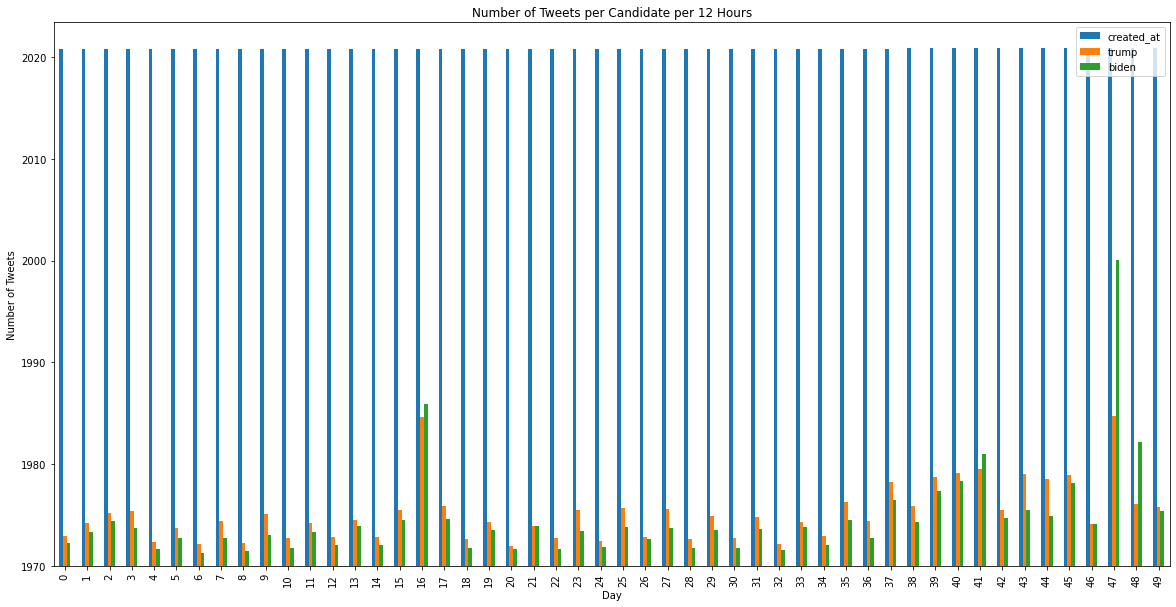

In [41]:
#Plotting bar graph to show how many tweets by day
combined_df.plot(kind='bar', title='Number of Tweets per Candidate per 12 Hours', figsize=(20,10), width = 0.5)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')

In [42]:
combined_df.to_sql("time_tweets", conn, if_exists="append", index=False)

2021-02-10 16:37:26,006 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("time_tweets")
2021-02-10 16:37:26,011 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 16:37:26,024 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 16:37:26,030 INFO sqlalchemy.engine.base.Engine INSERT INTO time_tweets (created_at, trump, biden) VALUES (?, ?, ?)
2021-02-10 16:37:26,033 INFO sqlalchemy.engine.base.Engine (('2020-10-15 00:00:00.000000', 1063, 814), ('2020-10-15 12:00:00.000000', 1535, 1239), ('2020-10-16 00:00:00.000000', 1912, 1601), ('2020-10-16 12:00:00.000000', 1958, 1366), ('2020-10-17 00:00:00.000000', 874, 612), ('2020-10-17 12:00:00.000000', 1382, 1009), ('2020-10-18 00:00:00.000000', 800, 478), ('2020-10-18 12:00:00.000000', 1616, 1012)  ... displaying 10 of 50 total bound parameter sets ...  ('2020-11-08 00:00:00.000000', 2211, 4434), ('2020-11-08 12:00:00.000000', 2134, 1988))
2021-02-10 16:37:26,044 INFO sqlalchemy.engine.base.Engine COMMIT
